In [2]:
%matplotlib inline
import os
import random
import sys
import time
import pickle
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [3]:
M, N = 10000, 1000

In [4]:
try:
    with open("data_train.pickle", "rb") as file:
        data, test = pickle.load(file)
        
except FileNotFoundError:
    def parse_line(line):
        coord, rating = line.split(',')
        user, film = coord.split('_')
        return (int(user[1:]), int(film[1:]), int(rating))

    data = sp.lil_matrix((M, N))
    test = sp.lil_matrix((M, N))
    with open("data_train.csv") as file:
        file.__next__() # skip header
        for line in file:
            user, film, rating = parse_line(line)
            if random.randrange(10) == 0:
                test[user-1, film-1] = rating
            else:
                data[user-1, film-1] = rating

    data = data.tocsr()
    test = test.tocsr()
    with open("data_train.pickle", mode="bw") as file:
        pickle.dump((data, test), file)

In [33]:
#The slow version
def rmse(test, guess):
    diffs = test - test.sign().multiply(guess)
    return np.sqrt(np.sum(np.square(diffs.data)) / diffs.nnz)
def k_means(data, test, K=10, tol=0.01, centroids=None):
    M, N = data.shape
    def get_assignments(centroids):
        assignments = np.zeros(M, dtype=np.int32)
        for user in range(M):
            dists = np.linalg.norm(data[user] - data[user].sign().multiply(centroids), axis=1)
            assignments[user] = np.argmin(dists)
        return assignments
    def get_centroids(assignments):
        centroids = np.zeros((K, N))
        counts = np.zeros((K, N))
        for k in range(K):
            centroids[k] = data[assignments == k].sum(0)
            counts[k] = data[assignments == k].sign().sum(0)
        counts[counts == 0] = 1
        return centroids / counts
    
    err = 999
    
    if centroids is None:
        centroids = np.random.rand(K, N) * 6 + 0.5
    while True:
        assignments = get_assignments(centroids)
        centroids = get_centroids(assignments)
        newerr = rmse(test, centroids[assignments])
        print(rmse(data, centroids[assignments]), newerr)
        if (err - newerr) / err < tol:
            break
        err = newerr
    return err, centroids, assignments

In [5]:
import pyximport
pyximport.install(reload_support=True)

(None, <pyximport.pyximport.PyxImporter at 0x108373438>)

In [6]:
import skm

1.00819538495


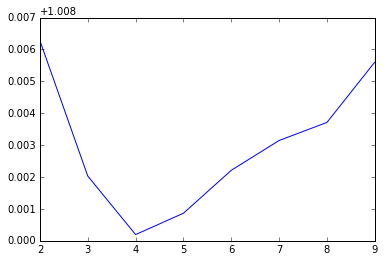

In [84]:
errs = []
for k in range(2, 10):
    err = min(skm.k_means(data, test, K=k, tol=0.0001)[0] for run in range(4))
    errs.append(err)
print(min(errs))
plt.plot(range(2, 10), errs)

In [63]:
err, centroids, assignments = skm.k_means(data, test, K=4, tol=0.0001)
err

1.0093911387810401

In [17]:
assignments[0]

7

In [15]:
centroids[:,9]

array([ 4.05414013,  3.2116041 ,  3.57507082,  3.89090909,  3.48630137,
        3.27155172,  4.09259259,  3.53378378])

In [16]:
data[0,9]

5.0

In [ ]:
plt.hist(data[:,9].data)

1.06195443972


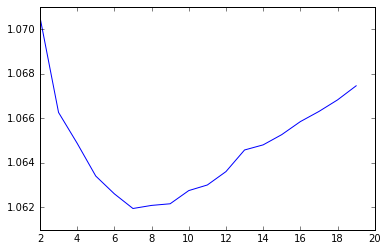

In [82]:
data1 = data.todense()
data1[data1 == 0] = 3.66
errs = []
U, s, V = np.linalg.svd(np.matrix(data1))
for k in range(2, 20):
    guess = np.array(U[:,0:k] * np.diag(s[0:k]) * V[0:k,:])
    errs.append(rmse(test, guess))
print(min(errs))
plt.plot(range(2, 20), errs)

0.998693246911


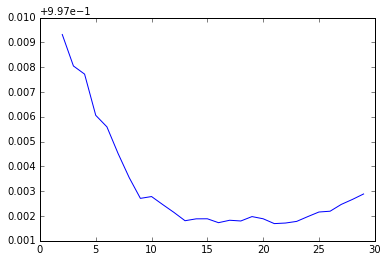

In [83]:
data2 = data.todense()
data2 = np.where(data2 != 0, data2, centroids[assignments])
errs = []
U, s, V = np.linalg.svd(np.matrix(data2))
for k in range(2, 30):
    guess = np.array(U[:,0:k] * np.diag(s[0:k]) * V[0:k,:])
    errs.append(rmse(test, guess))
print(min(errs))
plt.plot(range(2, 30), errs)